In [15]:
import csv
import cv2
import numpy as np
import tensorflow as tf
from PIL import Image
import random

## Prepare the train dataset

In [2]:
lines = []

images = []
measurements = []
correction = [0, 0.2, -0.2]

### Track 1 train dataset

In [3]:
with open("./train_data/track_2_normal_2/driving_log.csv") as csvfile:
    reader = csv.reader(csvfile)
    for line in reader:
            lines.append(line)

for line in lines:
    measurement = float(line[3])
    if(measurement > -0.05 and measurement < 0.05 and random.random() > 0.4):
        continue
    for i in range(3):
        source_path = line[i]
        filename = source_path.split('\\')[-1]
        current_path = './train_data/track_2_normal_2/IMG/' + filename
        image = Image.open(current_path)
        image = np.array(image.convert('YCbCr'))
        #image = cv2.cvtColor(image, cv2.COLOR_BGR2YUV)
        images.append(image)
        measurements.append(measurement + correction[i])

### Track 2 train dataset

In [4]:
lines = []
with open("./train_data/track_1_normal/driving_log.csv") as csvfile:
    reader = csv.reader(csvfile)
    for line in reader:
            lines.append(line)

for line in lines:
    measurement = float(line[3])
    if(measurement > -0.05 and measurement < 0.05 and random.random() > 0.3):
        continue
    for i in range(3):
        source_path = line[i]
        filename = source_path.split('\\')[-1]
        current_path = './train_data/track_1_normal/IMG/' + filename
        image = Image.open(current_path)
        image = np.array(image.convert('YCbCr'))
        images.append(image)
        measurements.append(measurement + correction[i])

### Augmenting train dataset

In [5]:
augmented_images, augmented_measurements = [], []
for image, measurement in zip(images, measurements):
    augmented_images.append(image)
    augmented_measurements.append(measurement)
    augmented_images.append(cv2.flip(image, 1))
    augmented_measurements.append(measurement*-1.0)

X_train = np.array(augmented_images)
y_train = np.array(augmented_measurements)

## Prepare the test dataset

In [5]:
lines = []

images = []
measurements = []

with open("./test_data/track_1/driving_log.csv") as csvfile:
    reader = csv.reader(csvfile)
    for line in reader:
            lines.append(line)

for line in lines:
    measurement = float(line[3])
    source_path = line[0]
    filename = source_path.split('\\')[-1]
    current_path = './test_data/track_1/IMG/' + filename
    image = Image.open(current_path)
    image = np.array(image.convert('YCbCr'))
    images.append(image)
    measurements.append(measurement)

lines = []
with open("./test_data/track_2/driving_log.csv") as csvfile:
    reader = csv.reader(csvfile)
    for line in reader:
            lines.append(line)

for line in lines:
    measurement = float(line[3])
    source_path = line[0]
    filename = source_path.split('\\')[-1]
    current_path = './test_data/track_2/IMG/' + filename
    image = Image.open(current_path)
    image = np.array(image.convert('YCbCr'))
    images.append(image)
    measurements.append(measurement)

X_test = np.array(images)
y_test = np.array(measurements)

## Statistic of the train dataset

(array([ 0.06968502,  0.01244375,  0.009955  ,  0.01244375,  0.01576209,
         0.01327334,  0.02820584,  0.01327334,  0.09872045,  0.04645668,
         0.05143418,  0.07798086,  0.08793586,  0.05973002,  0.07383294,
         0.10037962,  0.15596172,  0.15513214,  0.15264339,  0.23062425,
         0.26214842,  0.1974409 ,  0.24057925,  0.27956968,  0.25717092,
         0.31607136,  0.32685594,  0.34842512,  0.42806515,  0.42640598,
         0.41147347,  0.44299765,  0.54835477,  0.49775017,  0.50936434,
         0.60974396,  0.65620064,  0.64126813,  0.80552569,  0.71261233,
         0.58817478,  2.67374799,  0.5367406 ,  0.72256733,  0.93908865,
         0.81382153,  0.85944863,  0.98139742,  0.63214271,  0.63629063,
         2.76832052,  0.63214271,  0.98139742,  0.85944863,  0.81382153,
         0.93908865,  0.72256733,  0.5367406 ,  2.67374799,  0.58817478,
         0.71261233,  0.80552569,  0.64126813,  0.65620064,  0.60974396,
         0.50936434,  0.49775017,  0.54835477,  0.4

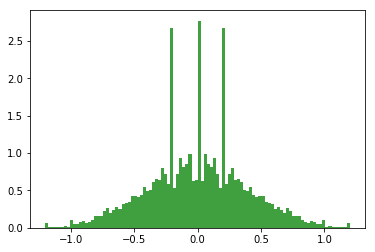

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.hist(augmented_measurements, 100, normed=1, facecolor='green', alpha=0.75)

In [8]:
from keras.models import Sequential
from keras.layers import Flatten, Dense, Lambda, Cropping2D, Dropout
from keras.layers.convolutional import Convolution2D
from keras.layers.pooling import MaxPooling2D

dropout_rate=0.2

model = Sequential()
model.add(Lambda(lambda x: x /255.0 - 0.5, input_shape=(160,320,3)))
# input 3@160x320
model.add(Cropping2D(cropping=((70,25), (0,0))))
# input 3@65x320
model.add(Convolution2D(24, 5, 5, activation="relu", subsample=(2,2)))
# input 24@31x158
model.add(Convolution2D(36, 5, 5, activation="relu", subsample=(2,2)))
# input 36@14x77
model.add(Convolution2D(48, 5, 5, activation="relu", subsample=(2,2)))
# input 48@5x37
model.add(Convolution2D(64, 3, 3, activation="relu"))
# input 64@3x35
model.add(Convolution2D(64, 3, 3, activation="relu"))
# input 64@1x32
model.add(Flatten())
model.add(Dropout(dropout_rate))
model.add(Dense(1164, activation="relu"))
model.add(Dropout(dropout_rate))
model.add(Dense(100, activation="relu"))
model.add(Dropout(dropout_rate))
model.add(Dense(50, activation="relu"))
model.add(Dropout(dropout_rate))
model.add(Dense(10, activation="relu"))
model.add(Dropout(dropout_rate))
model.add(Dense(1))

model.compile(loss='mse', optimizer='adam')

Using TensorFlow backend.


## Train the model

In [9]:
X_train = np.array(augmented_images)
y_train = np.array(augmented_measurements)

history = model.fit(X_train, y_train, validation_split=0.2, shuffle=True, nb_epoch=5)

model.save('model.h5')

Train on 40180 samples, validate on 10046 samples
Epoch 1/5
40180/40180 [==============================] - 63s - loss: 0.0752 - val_loss: 0.0456
Epoch 2/5
40180/40180 [==============================] - 60s - loss: 0.0588 - val_loss: 0.0501
Epoch 3/5
40180/40180 [==============================] - 60s - loss: 0.0531 - val_loss: 0.0495
Epoch 4/5
40180/40180 [==============================] - 61s - loss: 0.0494 - val_loss: 0.0562
Epoch 5/5
40180/40180 [==============================] - 63s - loss: 0.0453 - val_loss: 0.0483


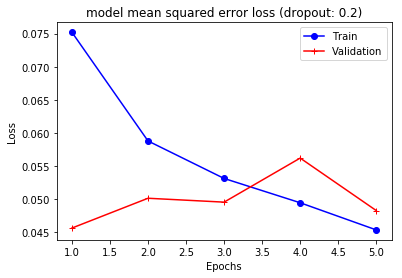

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline

history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, 'bo-', label='Train')
plt.plot(epochs, val_loss_values, 'r+-', label='Validation')
plt.xlabel('Epochs')
plt.title('model mean squared error loss (dropout: %.1f)' % dropout_rate)
plt.ylabel('Loss')
plt.legend()
plt.show()

## Test using train dataset

In [11]:
scores = model.evaluate(X_test, y_test, verbose=0)
print("Test score (dropout: %.1f) : %.3f" % (dropout_rate, scores))

Test score (dropout: 0.2) : 0.046


## Visualizing the internal CNN state

In [2]:
from keras.models import load_model

model = load_model("model.h5")

Using TensorFlow backend.


In [25]:
from keras.models import Sequential
from keras.layers import Flatten, Dense, Lambda, Cropping2D, Dropout
from keras.layers.convolutional import Convolution2D
from keras.layers.pooling import MaxPooling2D

model2 = Sequential()
model2.add(Lambda(lambda x: x /255.0 - 0.5, input_shape=(160,320,3)))
# input 3@160x320
model2.add(Cropping2D(cropping=((70,25), (0,0))))
# input 3@65x320
model2.add(Convolution2D(24, 5, 5, activation="relu", subsample=(2,2), weights=model.layers[2].get_weights()))
image = X_test[-100]
image_array = np.asarray(image)
    
activation = model2.predict(image_array[None, :, :, :], batch_size=1)

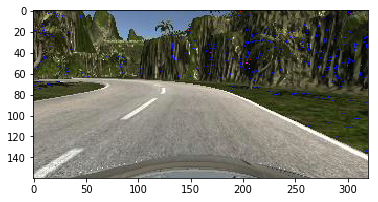

In [20]:
def ycbcr2rgb(im):
    xform = np.array([[1, 0, 1.402], [1, -0.34414, -.71414], [1, 1.772, 0]])
    rgb = im.astype(np.float)
    rgb[:,:,[1,2]] -= 128
    return np.uint8(rgb.dot(xform.T))

import matplotlib.pyplot as plt
%matplotlib inline
imageToShow = ycbcr2rgb(image)
plt.imshow(imageToShow)

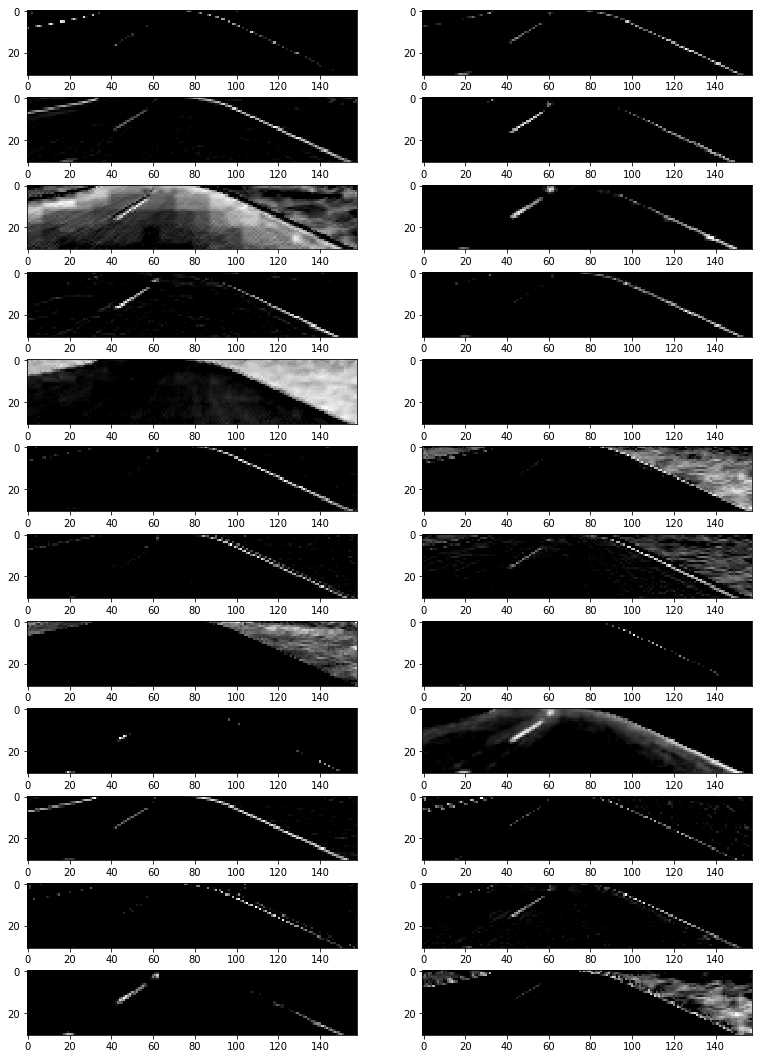

In [30]:
activation_min=-1
activation_max=-1 
plt_num=1

featuremaps = activation.shape[3]
plt.figure(plt_num, figsize=(13,19))
for featuremap in range(featuremaps):
    plt.subplot(12,2, featuremap+1) # sets the number of feature maps to show on each row and column
    #plt.title('FeatureMap ' + str(featuremap)) # displays the feature map number
    if activation_min != -1 & activation_max != -1:
        plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin =activation_min, vmax=activation_max, cmap="gray")
    elif activation_max != -1:
        plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmax=activation_max, cmap="gray")
    elif activation_min !=-1:
        plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin=activation_min, cmap="gray")
    else:
        plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", cmap="gray")

In [32]:
model3 = Sequential()
model3.add(Lambda(lambda x: x /255.0 - 0.5, input_shape=(160,320,3)))
# input 3@160x320
model3.add(Cropping2D(cropping=((70,25), (0,0))))
# input 3@65x320
model3.add(Convolution2D(24, 5, 5, activation="relu", subsample=(2,2), weights=model.layers[2].get_weights()))
# input 24@31x158
model3.add(Convolution2D(36, 5, 5, activation="relu", subsample=(2,2), weights=model.layers[3].get_weights()))
image = X_test[-100]
image_array = np.asarray(image)
    
activation = model3.predict(image_array[None, :, :, :], batch_size=1)

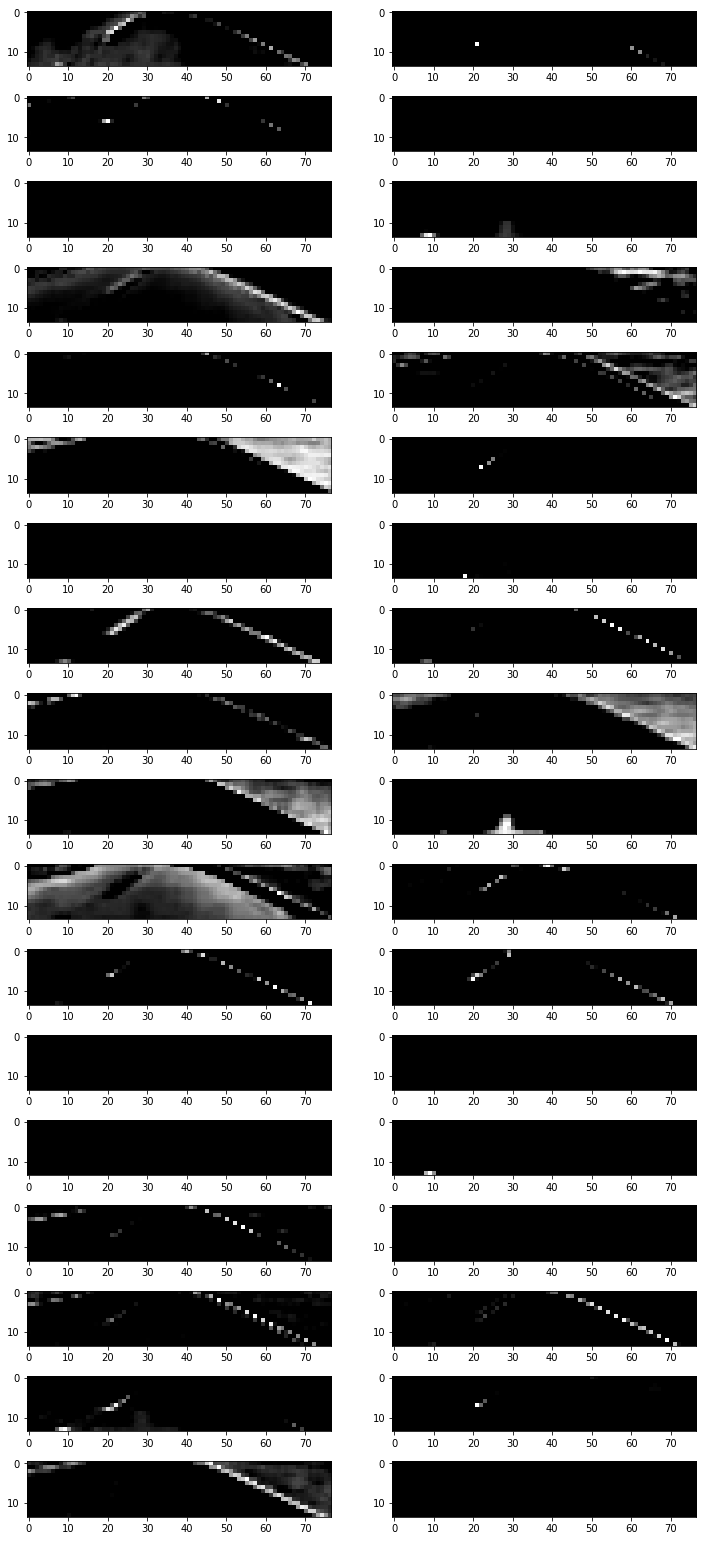

In [36]:
activation_min=-1
activation_max=-1 
plt_num=1

featuremaps = activation.shape[3]
plt.figure(plt_num, figsize=(12,28))
for featuremap in range(featuremaps):
    plt.subplot(18,2, featuremap+1) # sets the number of feature maps to show on each row and column
    #plt.title('FeatureMap ' + str(featuremap)) # displays the feature map number
    if activation_min != -1 & activation_max != -1:
        plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin =activation_min, vmax=activation_max, cmap="gray")
    elif activation_max != -1:
        plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmax=activation_max, cmap="gray")
    elif activation_min !=-1:
        plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin=activation_min, cmap="gray")
    else:
        plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", cmap="gray")